To run the Jupyter notebook on Google Colab:
1) Open Google Colab:
https://colab.research.google.com
2) In the pop-up window, click the "Upload" tab
3) Click "Choose file" → select your .ipynb file
4) Colab will open your notebook immediately.
5) In Colab in the top-right corner click "Connect"
6) In Colab in the bottom-right corner click "T4(Python 3)", select "Change runtime type" and make sure you use GPU

No need to install any python packages, everything is preinstalled in Colab

To run the Jupyter notebook locally on your laptop you need to install all the packages (pytorch, matplotlib):
1) pip install --upgrade pip
2) pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
3) pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu126
4) pip install matplotlib
5) pip install numpy
6) pip install scikit-learn



# Import all the necessary libraries

In [47]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np
from matplotlib.colors import LogNorm


# Load MNIST dataset

##### Compose multiple dataset preprocessing steps and load the dataset:
transforms.ToTensor() - converts to pytorch tensor, brings scale from 0-255 to 0-1

transforms.Normalize((0.1307,), (0.3081,)) - normalizes by mean and variance

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_data = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
validation_data  = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

100%|██████████| 9.91M/9.91M [00:00<00:00, 19.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 236kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.50MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.5MB/s]


# Define LeNet-5 model architecture
##### Model takes as an input images of 28x28 pixels grayscale (single channel)
<div style="background:white; padding:10px; display:inline-block;">
  <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/3/35/LeNet-5_architecture.svg/1200px-LeNet-5_architecture.svg.png" width="800">
</div>

You can make changes to the architecture. Make sure layer parameters match

In [4]:
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)  # 28x28 -> 24x24 -> 12x12 after pooling
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5) # 12x12 -> 8x8 -> 4x4 after pooling

        self.fc1 = nn.Linear(16*4*4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

        self.relu = nn.ReLU() # nonlinearity is ReLU
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x))) # (N, 1, 28, 28) -> (N, 6, 12, 12)
        x = self.pool(self.relu(self.conv2(x))) # (N, 6, 12, 12) -> (N, 16, 4, 4)

        x = x.view(x.size(0), -1)               # flatten
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

choosing a device "cuda" for GPU if available else "cpu"

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LeNet5().to(device) # create an instance of LeNet-5 on the chosen device

function to show number of trainable parameters and shape of the input per layer in LeNet

In [6]:
def count_params(model):
    print(f"{'Layer':30} {'Shape':25} {'Params'}")
    print("-" * 70)
    total = 0
    for name, param in model.named_parameters():
        if param.requires_grad:
            params = param.numel()
            total += params
            shape = list(param.shape)
            print(f"{name:30} {str(shape):25} {params}")
    print("-" * 70)
    print(f"Total Trainable Params: {total:,}")

In [7]:
count_params(model)

Layer                          Shape                     Params
----------------------------------------------------------------------
conv1.weight                   [6, 1, 5, 5]              150
conv1.bias                     [6]                       6
conv2.weight                   [16, 6, 5, 5]             2400
conv2.bias                     [16]                      16
fc1.weight                     [120, 256]                30720
fc1.bias                       [120]                     120
fc2.weight                     [84, 120]                 10080
fc2.bias                       [84]                      84
fc3.weight                     [10, 84]                  840
fc3.bias                       [10]                      10
----------------------------------------------------------------------
Total Trainable Params: 44,426


# Objective function

Next, we choose a loss function (Cross Entropy loss)

In [9]:
criterion = nn.CrossEntropyLoss() # loss function

# Train

### Prepare DataLoader
Dataloader allows batching, shuffling and parallel data loading

batch size is set to 256, you can change it

In [10]:
batch_size = 256 # batch size can be changed here

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True) # train data is prepared in batches
test_loader  = DataLoader(validation_data, batch_size=10000, shuffle=False) # test data is load fully as 1 batch

### choosing learning rate

In [11]:
learning_rate = 1e-2 # you can change learning rate here

### Optimization algorithm
Next, we choose an optimization algorithm (Stochastic Gradient Descend).

model.parameters() returns all trainable parameters of the Neural Network. Every nn.Module (like nn.Linear, nn.Conv2d, etc.) registers its trainable parameters automatically

In [12]:
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9) # optimization algorithm

### Function for 1 epoch of the training loop

In [13]:
def train(epoch):
    model.train() # sets model to train mode
    total_loss = 0
    correct = 0
    total = 0
    for batch_idx, (data, target) in enumerate(train_loader): # Loads one mini-batch of images and labels
        data, target = data.to(device), target.to(device) # Sends tensors to GPU if available, otherwise CPU

        optimizer.zero_grad() # Clears previous gradients stored in .grad. Necessary because PyTorch accumulates gradients
        output = model(data) # Model predicts class scores for the batch
        preds = output.argmax(dim=1) # Picks index of highest score per sample → predicted class
        correct += (preds == target).sum().item() # count correct predictions
        loss = criterion(output, target) # calculates the chosen loss (cross-entropy, squared error, etc.)
        loss.backward() # Computes gradients of loss w.r.t. model weights
        optimizer.step() # Applies gradient update using chosen algorithm (SGD, Adam, etc.)

        total += target.size(0)
        total_loss += loss.item() # Stores average loss across the epoch for printing

    print(f"Epoch {epoch+1}: loss = {total_loss / len(train_loader):.4f}")
    return total_loss / len(train_loader), 1 - correct / total

### Function for inference of the NN on the validation set

In [14]:
def validation():
    model.eval() # Puts network in evaluation mode
    total_loss = 0
    correct = 0
    total = 0
    with torch.no_grad(): # Disables gradient calculation. Makes testing faster & uses less memory
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            preds = output.argmax(dim=1) # Picks index of highest score per sample → predicted class
            correct += (preds == target).sum().item() # count correct predictions
            total += target.size(0)
            total_loss += loss.item()

    print(f"Test accuracy: {correct * 100.0 / total:.2f}%")
    return total_loss / len(test_loader), 1 - correct / total

### Function to calculate confusion matrix

In [24]:
def get_confusion_matrix(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            preds = outputs.argmax(dim=1)

            all_preds.append(preds.cpu().numpy())
            all_labels.append(y.cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    return confusion_matrix(all_labels, all_preds)

### The Actual training loop

In [25]:
def reset_weights(m): #reseting weights so the results of the last training loop are erased.
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        m.reset_parameters()

model.apply(reset_weights)

epochs = 10

train_losses = []
test_losses = []
train_errors = []
test_errors = []

train_cm_history = []
test_cm_history = []

for epoch in range(epochs):
    train_ls, train_err = train(epoch)
    test_ls, test_err = validation()

    train_losses.append(train_ls)
    train_errors.append(100*train_err)
    test_losses.append(test_ls)
    test_errors.append(100*test_err)

    train_cm = get_confusion_matrix(model, train_loader, device)
    test_cm  = get_confusion_matrix(model, test_loader, device)
    train_cm_history.append(train_cm)
    test_cm_history.append(test_cm)

Epoch 1: loss = 1.3068
Test accuracy: 90.04%
Epoch 2: loss = 0.2330
Test accuracy: 95.20%
Epoch 3: loss = 0.1363
Test accuracy: 96.74%
Epoch 4: loss = 0.0967
Test accuracy: 97.55%
Epoch 5: loss = 0.0790
Test accuracy: 97.68%
Epoch 6: loss = 0.0663
Test accuracy: 98.08%
Epoch 7: loss = 0.0578
Test accuracy: 98.31%
Epoch 8: loss = 0.0516
Test accuracy: 98.20%
Epoch 9: loss = 0.0466
Test accuracy: 98.43%
Epoch 10: loss = 0.0441
Test accuracy: 98.54%


Plotting loss function for both train and test

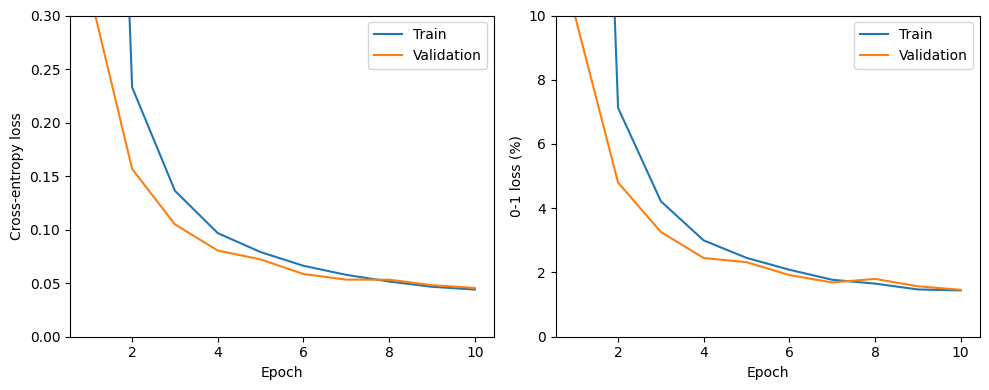

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Left: Loss
axes[0].plot(range(1, epochs+1), train_losses)
axes[0].plot(range(1, epochs+1), test_losses)
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Cross-entropy loss")
axes[0].set_ylim(0, 0.3)
# axes[0].set_title("Train/Test Loss")
axes[0].legend(["Train", "Validation"])

# Right: Error (1 - acc)
axes[1].plot(range(1, epochs+1), train_errors)
axes[1].plot(range(1, epochs+1), test_errors)
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("0-1 loss (%)")
# axes[1].set_title("Train/Test Error")
axes[1].legend(["Train", "Validation"])
axes[1].set_ylim(0, 10)

plt.tight_layout()
plt.show()

### Plotting confusion matrix

In [44]:
def plot_confusion_matrices_grid(cm_history, title_prefix="Epoch"):
    num_epochs = len(cm_history)

    cols = int(np.ceil(np.sqrt(num_epochs)))
    rows = int(np.ceil(num_epochs / cols))

    fig, axes = plt.subplots(rows, cols, figsize=(cols*4, rows*4))
    axes = axes.flatten()

    for i, cm in enumerate(cm_history):
        cm_safe = cm.copy()
        cm_safe[cm_safe == 0] = 1  # needed for LogNorm

        sns.heatmap(
            cm_safe,
            cmap="magma",
            norm=LogNorm(vmin=1, vmax=cm_safe.max()),   # This makes small values visible
            annot=False,
            fmt="d",
            cbar=True,
            ax=axes[i]
        )
        axes[i].set_title(f"{title_prefix} {i+1}")
        axes[i].set_xlabel("Predicted")
        axes[i].set_ylabel("True")

    # Hide leftover unused cells
    for j in range(i+1, len(axes)):
        axes[j].axis("off")

    fig.tight_layout()
    plt.show()


Confusion matrix on train data

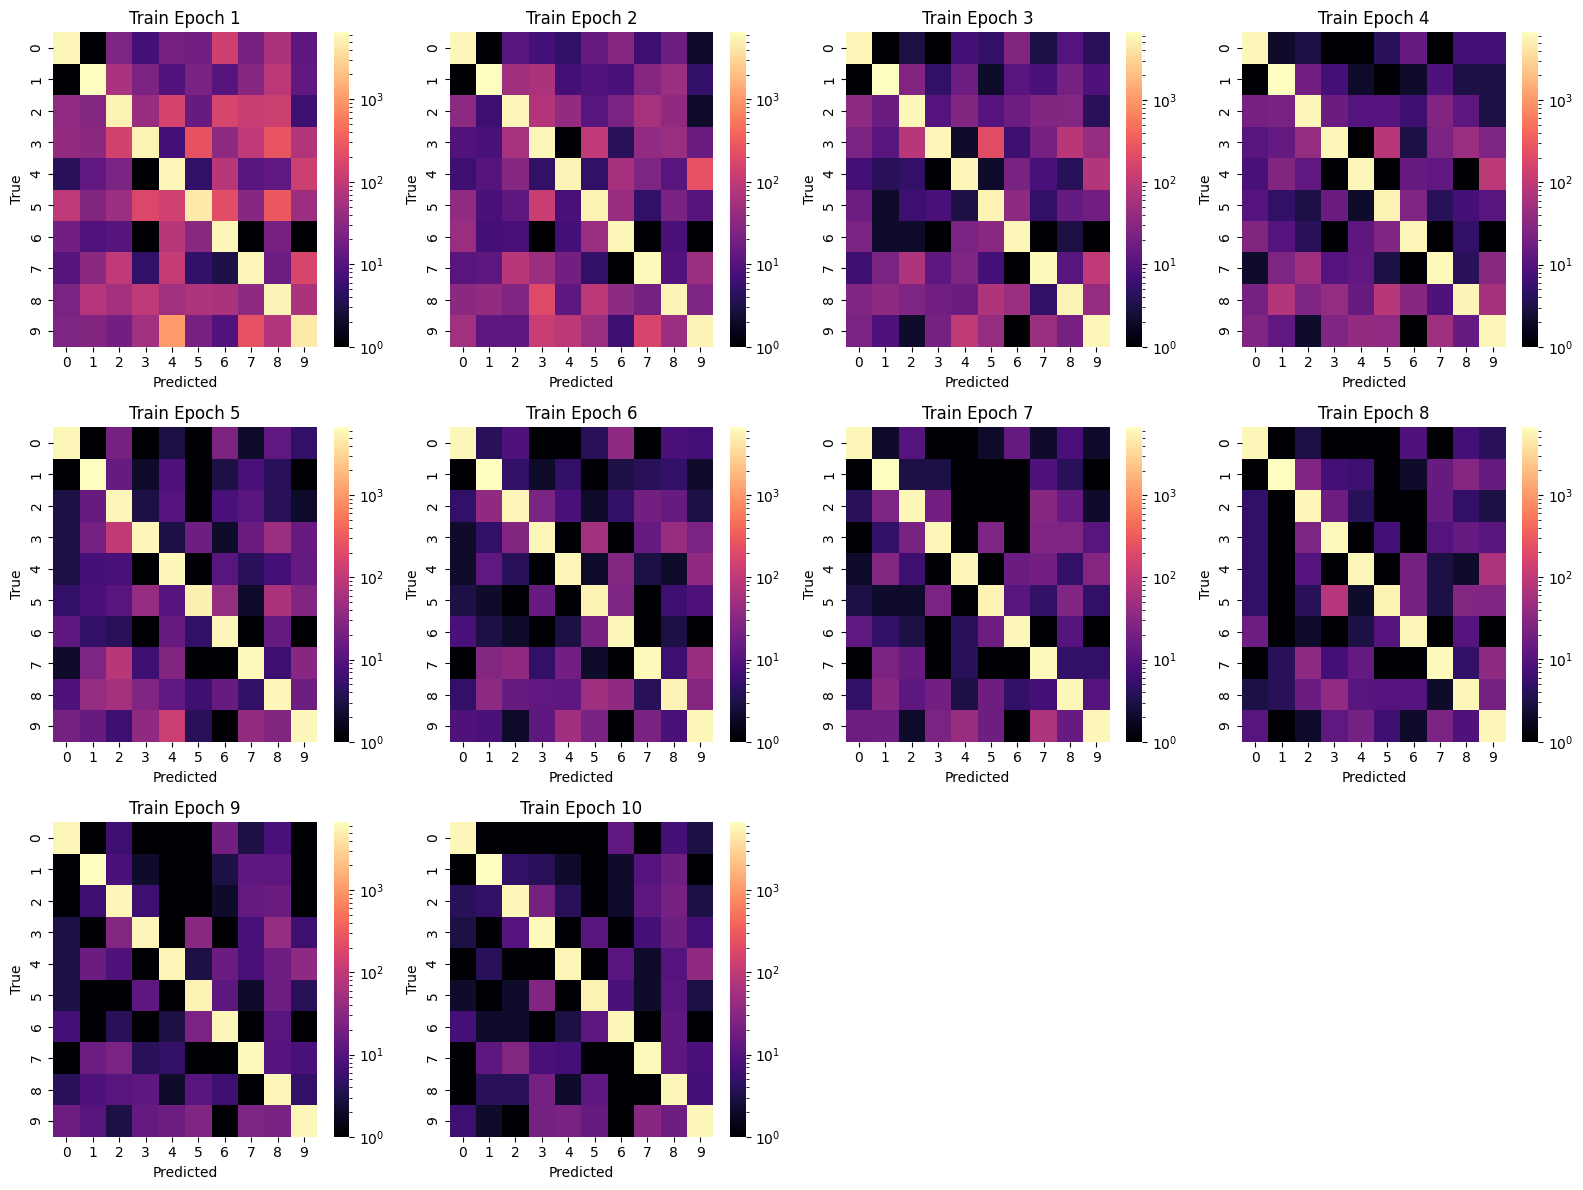

In [45]:
plot_confusion_matrices_grid(train_cm_history, title_prefix="Train Epoch")

Confusion matrix on test data

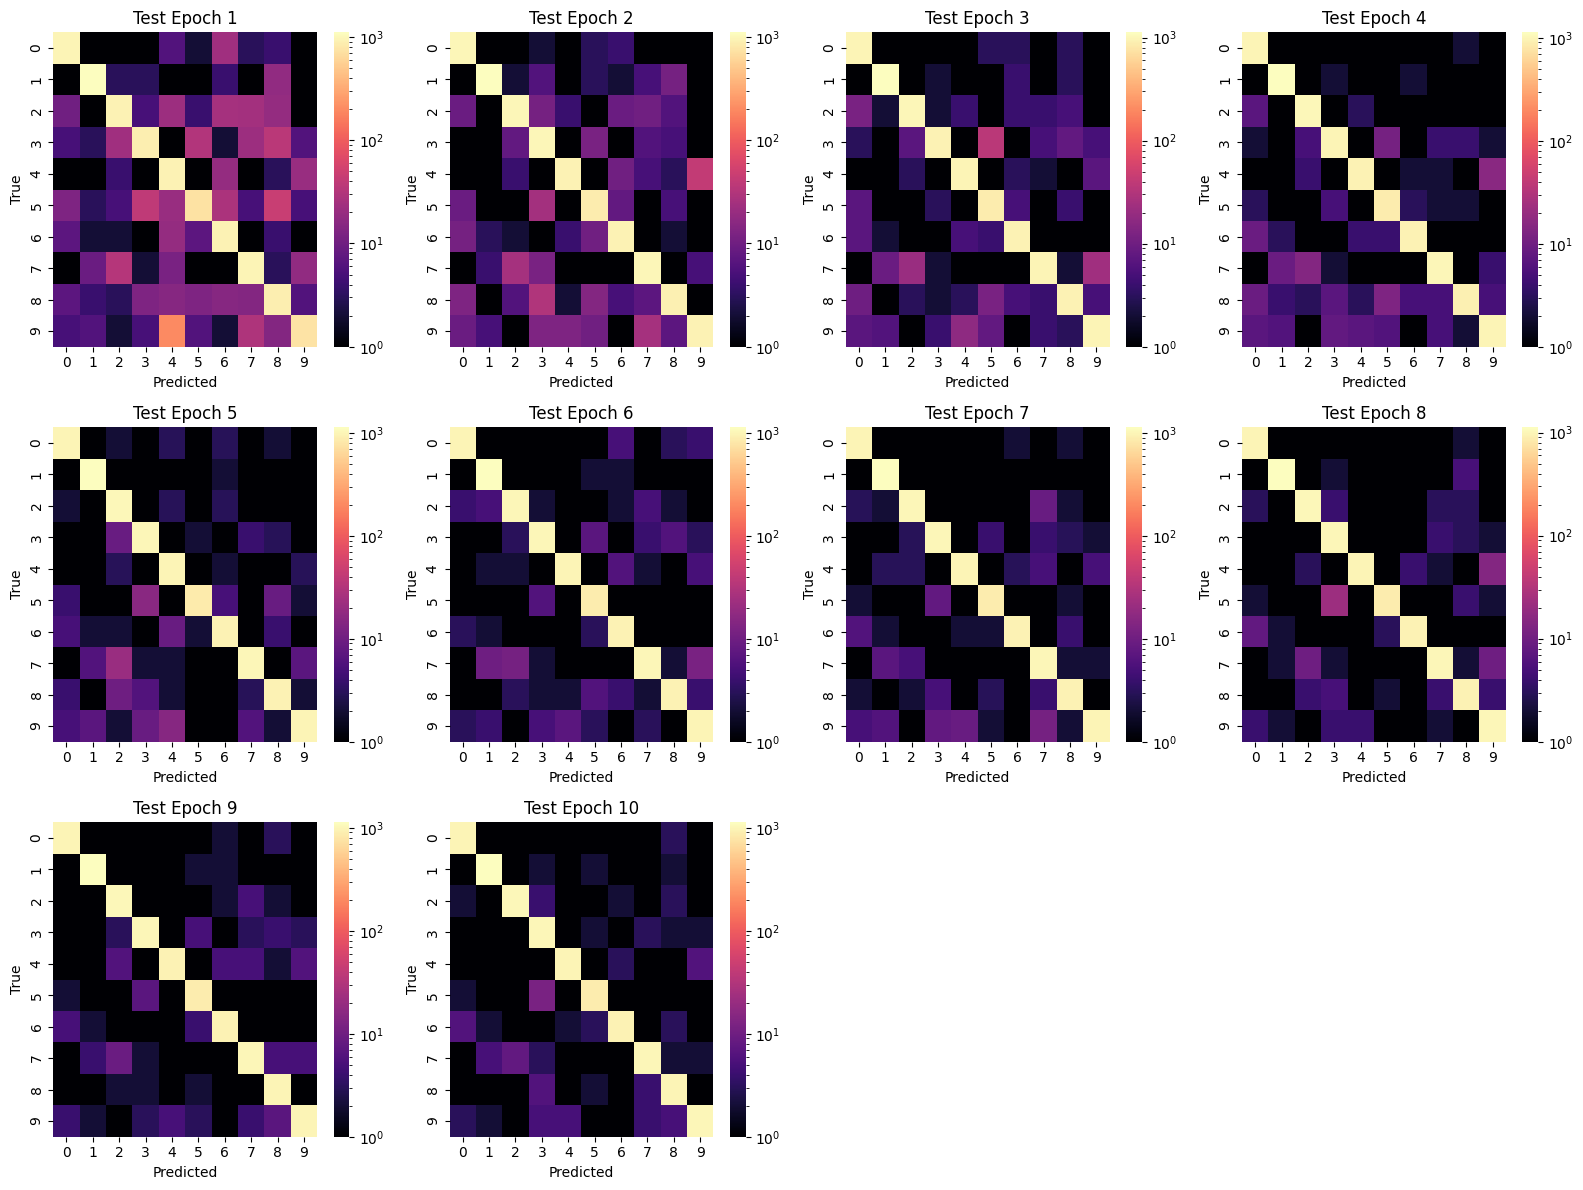

In [46]:
plot_confusion_matrices_grid(test_cm_history, title_prefix="Test Epoch")

Things to do:
1) Try different hidden layer sizes [Go to section](#scrollTo=l2dFZYW3uKp9)

2) Try different learning rates [Go to section](#scrollTo=ZyJ5B0zGuKp-)

3) Try different batch sizes [Go to section](#scrollTo=WL8udzY9uKp9)

When making changes to the selected cell run all the cells below

# Plotting convolutional filters
In filter visualization:

blue are values above 0

white are values equal to 0

red are values bigger than 0

In [56]:
def visualize_conv_filters(model):
    for name, layer in model.named_modules():
        if isinstance(layer, torch.nn.Conv2d):
            W = layer.weight.data.clone()

            # Normalize weights to [0,1]
            # W = (W - W.min()) / (W.max() - W.min())

            out_channels = W.shape[0]
            in_channels = W.shape[1]

            print(f"\nVisualizing {name}: {out_channels} filters, each with {in_channels} channel kernels")

            # For each filter (output channel)
            for f in range(out_channels):
                fig, axes = plt.subplots(1, in_channels, figsize=(in_channels * 2, 2))
                fig.suptitle(f"{name} — Filter {f}")

                # If only 1 channel, matplotlib gives a single axis, wrap it
                if in_channels == 1:
                    axes = [axes]

                for c in range(in_channels):
                    w = W[f, c].cpu().numpy()
                    vmax = np.abs(w).max()  # symmetric range
                    vmin = -vmax
                    axes[c].imshow(w, cmap='bwr', vmin=vmin, vmax=vmax)
                    axes[c].axis('off')

                plt.tight_layout()
                plt.show()



Visualizing conv1: 6 filters, each with 1 channel kernels


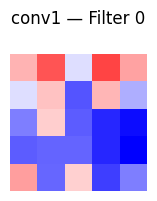

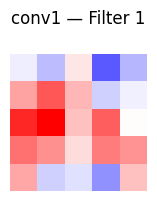

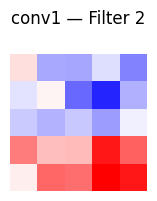

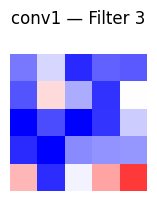

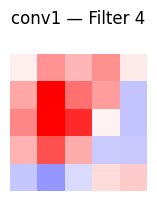

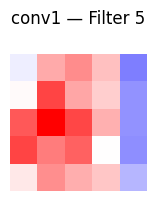


Visualizing conv2: 16 filters, each with 6 channel kernels


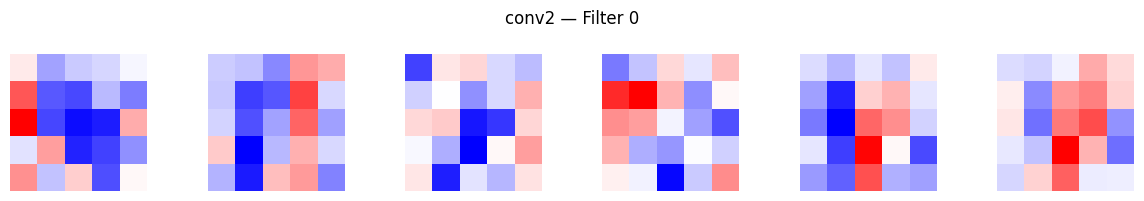

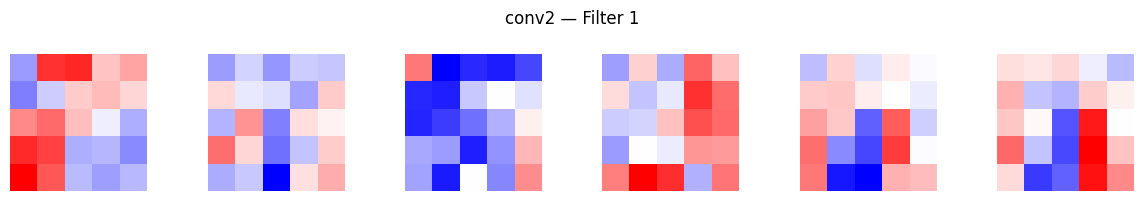

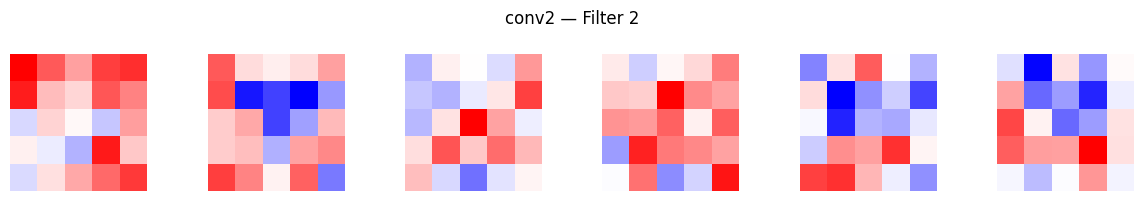

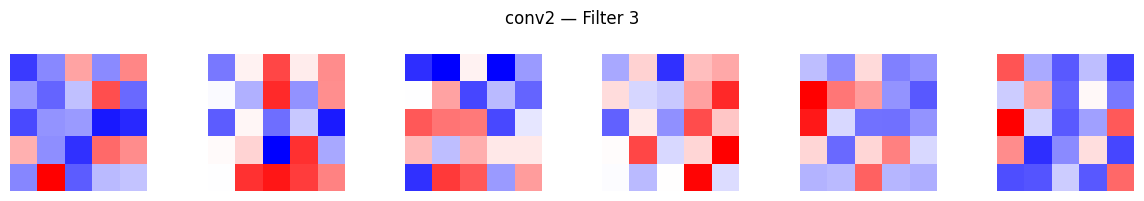

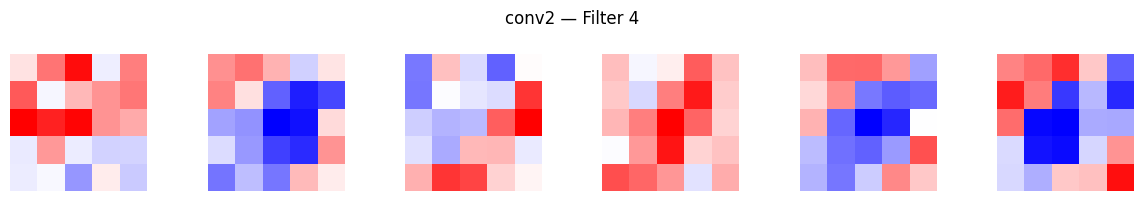

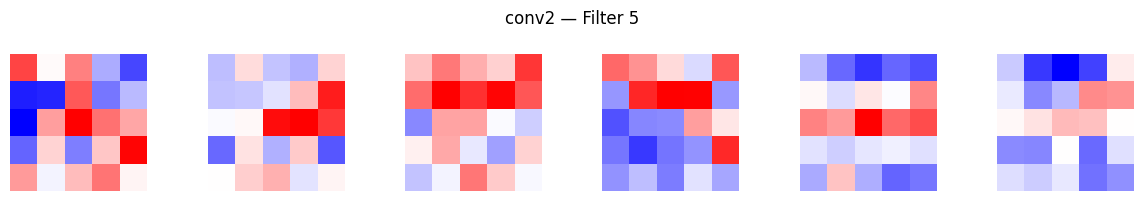

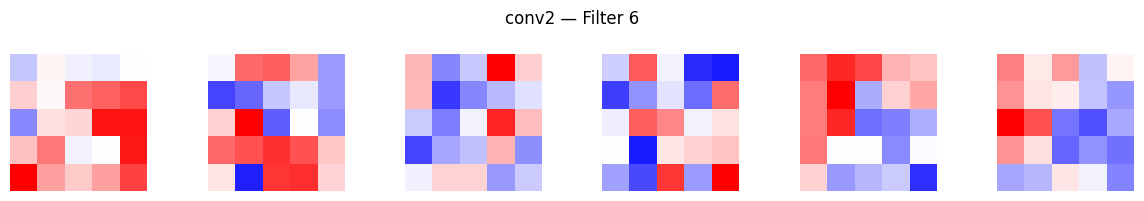

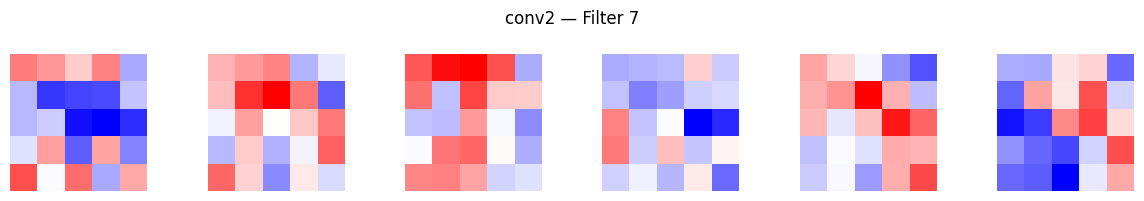

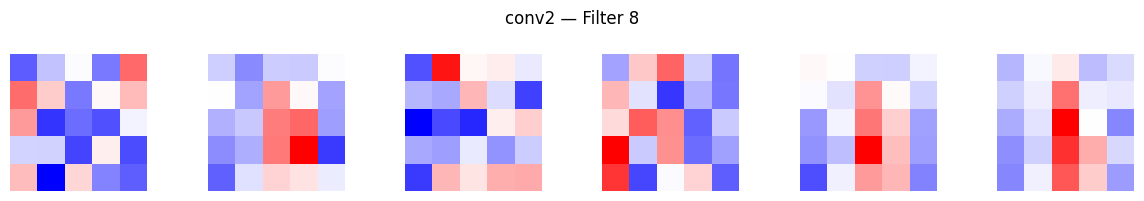

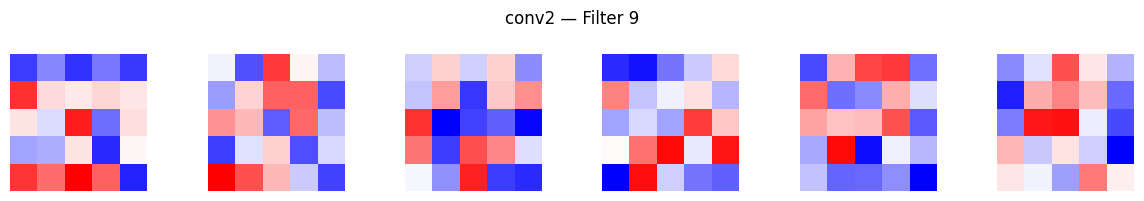

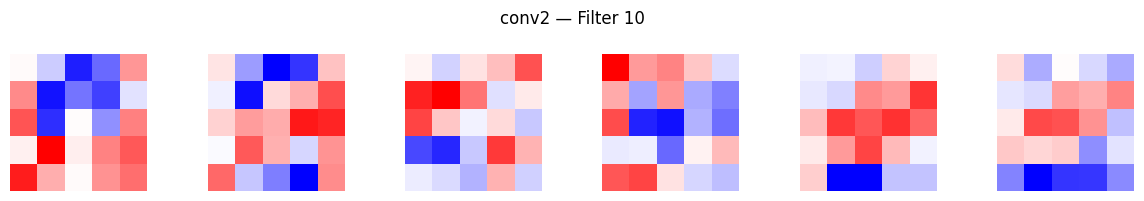

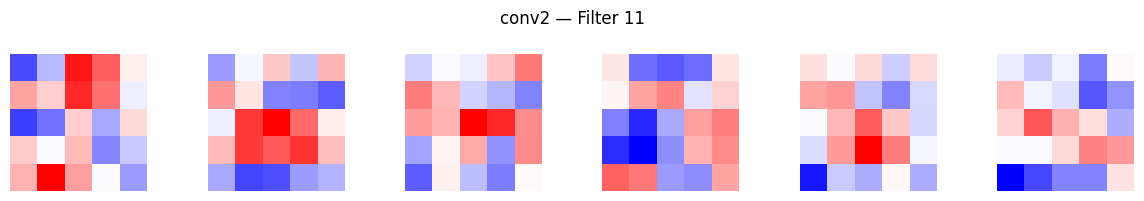

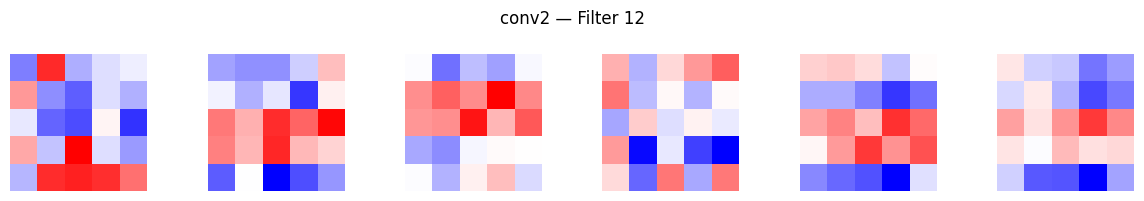

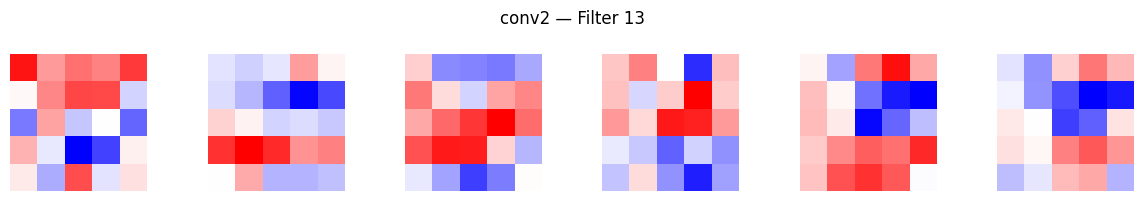

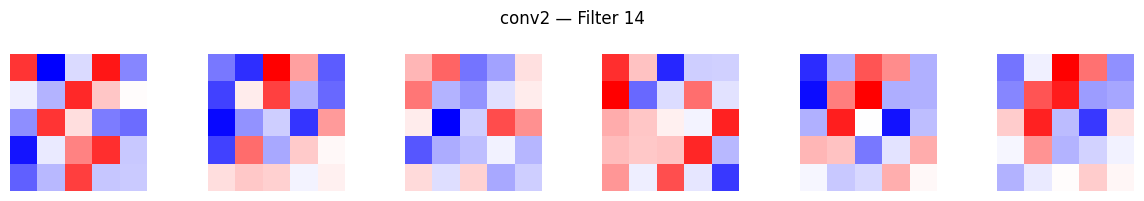

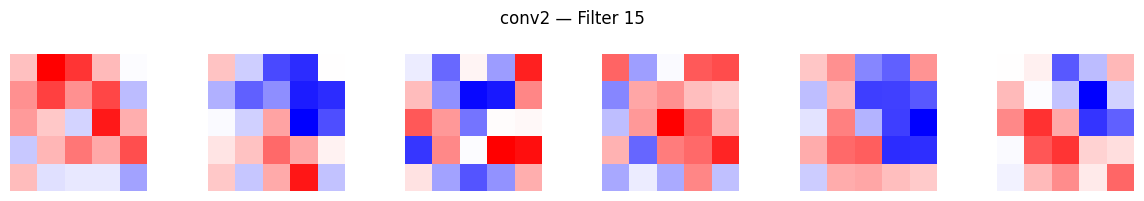

In [57]:
visualize_conv_filters(model)

##### Visualization of the feature map output it produces for an MNIST digit. In filter visualization:

blue are values above 0

white are values equal to 0

red are values bigger than 0

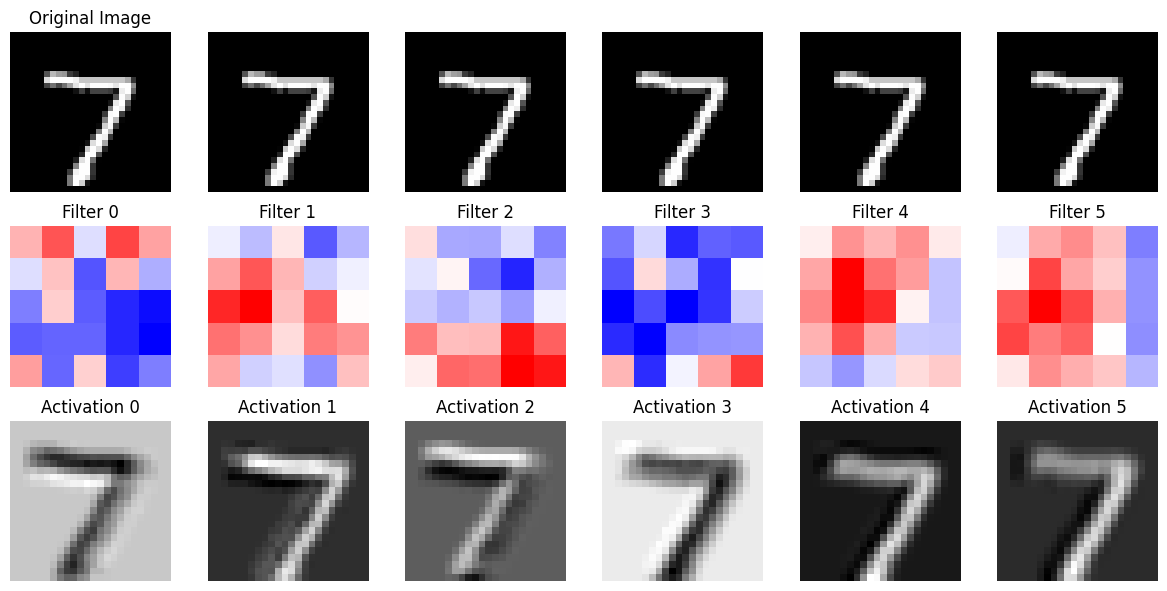

In [51]:
# Pick a sample MNIST image from test set
sample_img, sample_label = validation_data[0]  # first test image
input_img = sample_img.unsqueeze(0).to(device)  # add batch dimension

# Get conv1 weights and forward pass
model.eval()
with torch.no_grad():
    conv1_output = model.conv1(input_img)  # shape: [1,6,H,W]

num_filters = conv1_output.shape[1]

# Plot
fig, axes = plt.subplots(3, num_filters, figsize=(num_filters*2, 6))

for i in range(num_filters):
    # Original image (top row)
    axes[0, i].imshow(sample_img[0].cpu().numpy(), cmap='gray')
    axes[0, i].axis('off')
    if i == 0:
        axes[0, i].set_title(f"Original Image")

    # Conv1 filter weights (middle row)
    filter_w = model.conv1.weight.data[i, 0].cpu().numpy()  # [5,5]
    vmax = np.abs(filter_w).max()  # symmetric range
    vmin = -vmax
    axes[1, i].imshow(filter_w, cmap='bwr', vmin=vmin, vmax=vmax)
    axes[1, i].axis('off')
    axes[1, i].set_title(f"Filter {i}")

    # Feature map (bottom row)
    feature_map = conv1_output[0, i].cpu().numpy()
    axes[2, i].imshow(feature_map, cmap='gray')
    axes[2, i].axis('off')
    axes[2, i].set_title(f"Activation {i}")

plt.tight_layout()
plt.show()
